<a href="https://colab.research.google.com/github/ValentinoFernandez/IA_SIS420/blob/main/Lab_4_regresi%C3%B3n_one_vs_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 4 - Regresión one vs all (Multiclase)

Primero, importamos las librerias necesarias para el ejercicio

In [1]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
import matplotlib.pyplot as plt

# Modulo de optimizacion en scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

#Para el manejo del dataset
import pandas as pd

#Para separar los valores de prueba y entrenamiento
from sklearn.model_selection import train_test_split

#Para normalizar los datos
from sklearn.preprocessing import StandardScaler

from scipy.optimize import minimize

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Subimos el dataset para poder hacer uso de sus datos. Además separamos las caracteristicas de nuestra varibale objetivo que tiene las distintas clases.

In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/Sistemas/Universidad - Sistemas/7mo semestre/IA/Laboratorio/Laboratorio4/covertype.csv', delimiter=',')
# print(data)
# Separamos caracteristicas de las clases
X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type']
print(X.shape)
print(y.shape)

data

(581012, 54)
(581012,)


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


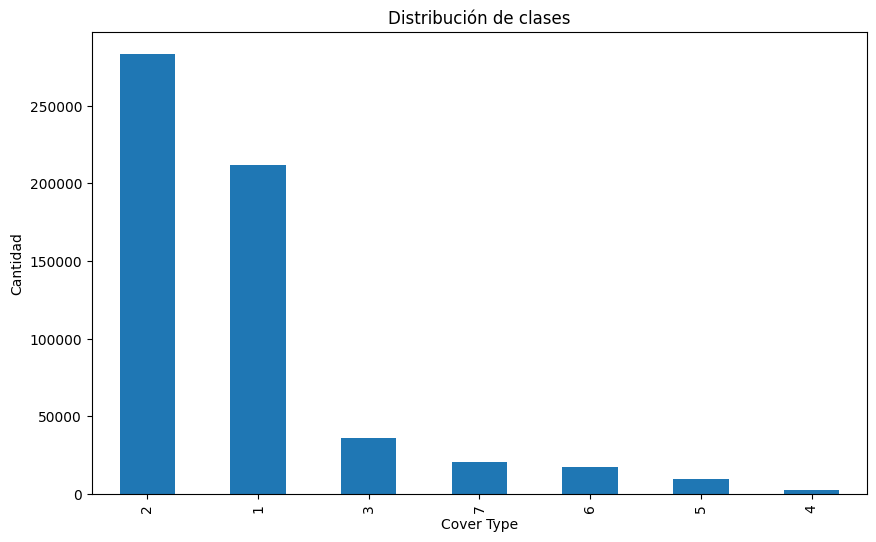

In [32]:
# Visualizamos la distribución de las clases
plt.figure(figsize=(10, 6))
y.value_counts().plot(kind='bar')
plt.title('Distribución de clases')
plt.xlabel('Cover Type')
plt.ylabel('Cantidad')
plt.show()

Normalizamos los datos del dataset con la función "StandartScaler" y separamos los datos en 80% de entrenamiento y 20% prueba

In [4]:
# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separamos los datos de entrenamiento 80% y los datos de prueba 20%
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (464809, 54)
Testing set shape: (116203, 54)


In [5]:
y

,Cover_Type
0,5
1,5
2,2
3,2
4,5
...,...
581007,3
581008,3
581009,3
581010,3


Podemos interpretar que en este dataset tenemos 54 variables de entrada o columnas que estarán en la "X" y 7 clases que se encuentran en la columna covertype guardada en la "Y".  

In [6]:
# data.shape
X.shape[1]

54

In [7]:
input_layer_size  = 54
num_labels = 7
m = y.size

La función "calcular Sigmoid" convierte los valores lineales de la combinación lineal de características a probabilidades en el rango (0, 1).

In [8]:
def  calcularSigmoide(z):
    return 1 / (1 + np.exp(-z))

La función de "calcular costo" calcula el costo regularizado para un conjunto de parámetros theta

In [9]:
def calcularCosto(theta, X, y, lambda_):
    m = y.size

    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    # Calcula la hipótesis
    h = calcularSigmoide(X.dot(theta))

    # Crea una copia de theta para regularizar
    temp = theta.copy()
    temp[0] = 0  # No regularizamos el término de sesgo (bias)

    # Calcula el costo con regularización
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    # Calcula el gradiente con regularización
    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad

La función "optimizar_theta" nos permite registrar el costo en cada iteración para poder resolver el gráfico de convergencia del costo

In [10]:
def optimizar_theta(theta_init, X, y, lambda_):
    J_history = []  # Lista para almacenar el historial de costo

    def callback(theta):
        J, _ = calcularCosto(theta, X, y, lambda_)
        J_history.append(J)

    # Minimización usando BFGS y almacenamiento del historial de costo
    res = minimize(fun=lambda t: calcularCosto(t, X, y, lambda_)[0],
                   x0=theta_init,
                   method='BFGS',
                   jac=lambda t: calcularCosto(t, X, y, lambda_)[1],
                   callback=callback)

    return res.x, J_history


Utilizamos valores de entrenamiento para sacar los valores de costo y de la gradiante

In [11]:
# Definimos el tamaño de theta según el número de características en X_train

n_features = X_train.shape[1]  # Cantidad de características en X (sin contar el sesgo)
theta_init = np.zeros(n_features + 1)  # Agregamos 1 para el término de sesgo

# Seleccionamos las primeras 5 filas de X_train para testeo y agregamos la columna de 1s (bias)
X_t = X_train[:5, :]
y_t = y_train[:5]

# Parámetro de regularización
lambda_ = 3

# Agregamos la columna de 1s para el término de sesgo (bias)
X_t = np.concatenate([np.ones((X_t.shape[0], 1)), X_t], axis=1)



In [12]:
# Calculamos el costo y el gradiente con los valores de prueba
J, grad = calcularCosto(theta_init, X_t, y_t, lambda_)

# Mostramos los resultados
print('-----------------------')
print('Costo         : {:.6f}'.format(J))
print('-----------------------')
print('Gradientes:')
print(grad)

-----------------------
Costo         : 0.693147
-----------------------
Gradientes:
[-0.9        -0.42706376 -0.13589832  0.19942391  0.46100106  0.28436261
 -0.52029259 -0.03618084 -0.52169165 -0.29849024  0.14043418  0.20905328
 -0.24315709 -0.21684713  0.23460565  0.06517465  0.10309414  0.08234148
  0.13288433  0.04724981  0.09628734  0.01209996  0.0157995   0.04002771
  0.21955213  0.13296098  0.20989455  0.1582798   0.02891261  0.00204509
  0.06313308  0.06927439  0.0515375   0.07513201  0.11453028  0.03420467
 -0.2076003   0.29899729 -0.356913    0.02571677  0.06021238  0.03894674
  0.03634539 -0.30464315  0.21062826  0.19348165 -0.76251901 -0.11226282
  0.04745704  0.05142847  0.01288154  0.02038776  0.1493605   0.14041259
  0.11128819]


Y realizamos el gráfico de convergencia de costo

<ipython-input-9-e3b9fd888acd>:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-9-e3b9fd888acd>:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-9-e3b9fd888acd>:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-9-e3b9fd888acd>:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-9-e3b9fd888acd>:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.s

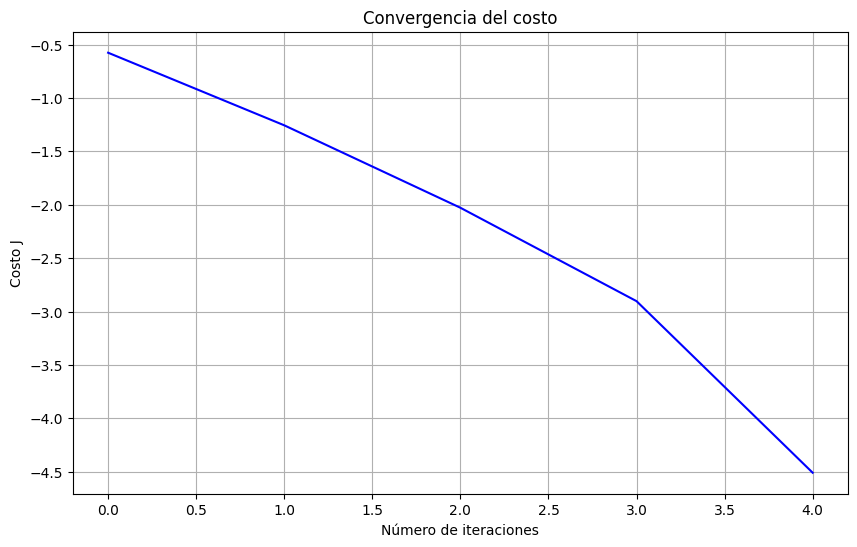

Número de iteraciones: 6


In [13]:
# Optimizamos theta y obtenemos el historial del costo
theta_opt, J_history = optimizar_theta(theta_init, X_t, y_t, lambda_)

# Graficamos la convergencia del costo
plt.figure(figsize=(10, 6))
plt.plot(range(len(J_history)), J_history, 'b-')
plt.title("Convergencia del costo")
plt.xlabel("Número de iteraciones")
plt.ylabel("Costo J")
plt.grid(True)
plt.show()

print(f"Número de iteraciones: {len(J_history)}")

También realizamos pruebas con valores generados para X y Y.

In [15]:
# generar datos de ejemplo:
#np.random.seed(42)
#X_tr = np.random.rand(100, 5)
#y_tr = np.random.randint(0, 2, 100)

#n_features = X_train.shape[1]
#theta_init = np.zeros(n_features + 1)

# Agregamos la columna de 1s para el término de sesgo (bias)
#X = np.concatenate([np.ones((X_tr.shape[0], 1)), X_tr], axis=1)

#lambda_ = 3

# Optimizamos theta y obtenemos el historial del costo
#theta_opt, J_history = optimizar_theta(theta_init, X, y_tr, lambda_)


Se puede apreciar que los resultados son aceptables en comparación con los anteriores

In [17]:
# Graficamos la convergencia del costo
#plt.figure(figsize=(10, 6))
#plt.plot(range(len(J_history)), J_history, 'b-')
#plt.title("Convergencia del costo")
#plt.xlabel("Número de iteraciones")
#plt.ylabel("Costo J")
#plt.grid(True)
#plt.show()

#print(f"Número de iteraciones: {len(J_history)}")
#print(f"Costo final: {J_history[-1]:.6f}")

# Calculamos el costo y el gradiente final
#J_final, grad_final = calcularCosto(theta_opt, X, y_train, lambda_)

#print('-----------------------')
#print('Costo final    : {:.6f}'.format(J_final))
#print('-----------------------')
#print('Gradientes finales:')
#print(grad_final)

  Ahora aplicamos el algoritmo de One vs all para poder sacar all_theta con todos los parametros que sirve para clasificar cada clase. En otras palabras es un clasificador para cada clase contra todas las demás. Como un regresión logística para varias clases ya no solo binaria.

In [18]:
def oneVsAll(X, y, num_labels, lambda_):

    m, n = X.shape

    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)


    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 100}
        res = optimize.minimize(calcularCosto,
                                initial_theta,
                                (X, (y == (c + 1)), lambda_),
                                jac=True,
                                method='BFGS',
                                options=options)

        all_theta[c] = res.x

    return all_theta

Ahora llamamos a la función oneVsAll para entrenar modelos de regresión logística para cada una de las clases (manejadas por num_labels), usando un valor muy pequeño de lambda_ que favorece el ajuste del modelo sobre la regularización.

In [19]:
lambda_ = 0.001
all_theta = oneVsAll(X_train, y_train, num_labels, lambda_)

In [20]:
print(all_theta)

[[-1.56194467e+00  1.96617067e+00 -3.68053509e-02 -5.77751296e-02
  -3.00746790e-01 -9.19250429e-02 -1.47989378e-01  2.75855644e-01
  -6.74458785e-01  6.09912870e-01 -1.34183761e-02  4.75140691e-01
  -1.96425476e-02  1.56827065e-01 -1.26903866e+00 -1.01751053e-01
  -7.16276120e-01 -5.11234570e-01 -6.67066727e-02 -8.40496935e-02
  -2.72112522e-01 -1.44413447e-01  4.65981131e-03  5.78302617e-02
   6.44364431e-02  1.61443632e-02 -1.11733187e-01  3.23157542e-03
  -1.43758907e-01 -2.19834540e-03  4.25226487e-02  3.78825278e-02
  -6.20915947e-03  6.49724325e-02  1.23909774e-01  1.35379454e-01
   2.90784672e-01  2.79303716e-01  1.32785875e-01 -1.99157029e-02
  -3.43413657e-04  4.37707213e-02 -1.67984046e-02 -2.65546983e-02
  -4.78819941e-02  1.33624028e-01  5.20714353e-02  1.61080404e-01
  -7.73896743e-02 -8.53400659e-02 -2.84003213e-02 -3.99415149e-01
  -1.43051097e-01 -1.37918406e-01 -1.78405684e-01]
 [-2.53196221e-01 -1.54865637e+00 -3.60345265e-02  1.19421101e-01
   3.26817934e-01  2.8185

Ahora utilizamos la función de "predicOnevsAll" que predice qué clase tiene la mayor probabilidad para cada ejemplo de entrada basándose en los parámetros aprendidos.

In [29]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0];

    #obtiene el número de clases a partir de la primera dimensión de all_theta
    num_labels = all_theta.shape[0]

    #crea un vector de ceros con longitud m, donde cada elemento almacenará la clase predicha para cada ejemplo.
    p = np.zeros(m)

    # agrega una columna de 1's al principio de X para manejar el término de sesgo en los cálculos.
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    #encuentra el índice de la máxima probabilidad a lo largo del eje 1 (es decir, entre las clases), asignando a cada ejemplo la clase con la mayor probabilidad predicha.
    p = np.argmax(calcularSigmoide(X.dot(all_theta.T)), axis = 1)

    print(p+1)

    return p + 1

Ahora predecimos las clases para los conjuntos de entrenamiento (X_train) y de prueba (X_test) usando los parámetros entrenados all_theta.

In [30]:
train_pred = predictOneVsAll(all_theta, X_train)
test_pred = predictOneVsAll(all_theta, X_test)

print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(train_pred == y_train) * 100))
print('Precision del conjuto de prueba: {:.2f}%'.format(np.mean(test_pred == y_test) * 100))

[1 1 2 ... 1 1 1]
[1 2 2 ... 2 2 7]
Precision del conjuto de entrenamiento: 71.55%
Precision del conjuto de prueba: 71.57%
